# Sentiment Analysis - BERT training

### Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import os
import math
from collections import defaultdict
from textwrap import wrap
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder

import wandb

import nltk.data
from nltk.tokenize import sent_tokenize
from nltk.corpus import alpino

from imblearn.over_sampling import RandomOverSampler

### Configure

Libraries settings

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Model settings

In [11]:
DATA_DIR = "/home/leonardovida/dev/hist-aware/notebooks/data/labeled"
PRE_TRAINED_MODEL_NAME = 'wietsedv/bert-base-dutch-cased'

In [12]:
!nvidia-smi

Thu Jun 10 15:05:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:00:05.0 Off |                  N/A |
| 30%   30C    P8    21W / 250W |      3MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!sudo kill -25234 pid

Wandb settings to track experiment

### Import data

In [14]:
df = pd.read_csv(os.path.join(DATA_DIR, "labeled_split_sents_energy_1960_1990.csv"))
oil = pd.read_csv(os.path.join(DATA_DIR, "labeled_split_sents_oil_1960_1990.csv"))
gas = pd.read_csv(os.path.join(DATA_DIR, "labeled_split_sents_gas_1960_1990.csv"))
coal = pd.read_csv(os.path.join(DATA_DIR, "labeled_split_sents_coal_1960_1990.csv"))

Create holdout set

In [15]:
from collections import Counter
holdout_df = df.sample(300)

df = df.drop(holdout_df.index, axis = 0)

print("Holdout set ", Counter(holdout_df.labels))
print("Training set ",Counter(df.labels))

Holdout set  Counter({1.0: 154, 0.0: 90, 2.0: 56})
Training set  Counter({1.0: 20435, 0.0: 11663, 2.0: 6777})


In [16]:
from sklearn.model_selection import train_test_split

X = df.text.values
y = df.labels.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)
print("Validation set examples ", X_val.shape ,"  y_val ", y_val.shape)

Validation set examples  (3888,)   y_val  (3888,)


### Load Pre-trained BERT model

In [17]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Verify the max tokens length in text_split

In [18]:
MAX_LEN = 0
def max_len(x):
    lengths = []
    lengths.append(len(tokenizer.encode(x.split())))
    return(lengths)
    
temp = df["text_split"].apply(max_len)
MAX_LEN = max(temp)
MAX_LEN

Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


[528]

In [20]:
token_lens = []
for txt in df.text_split:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

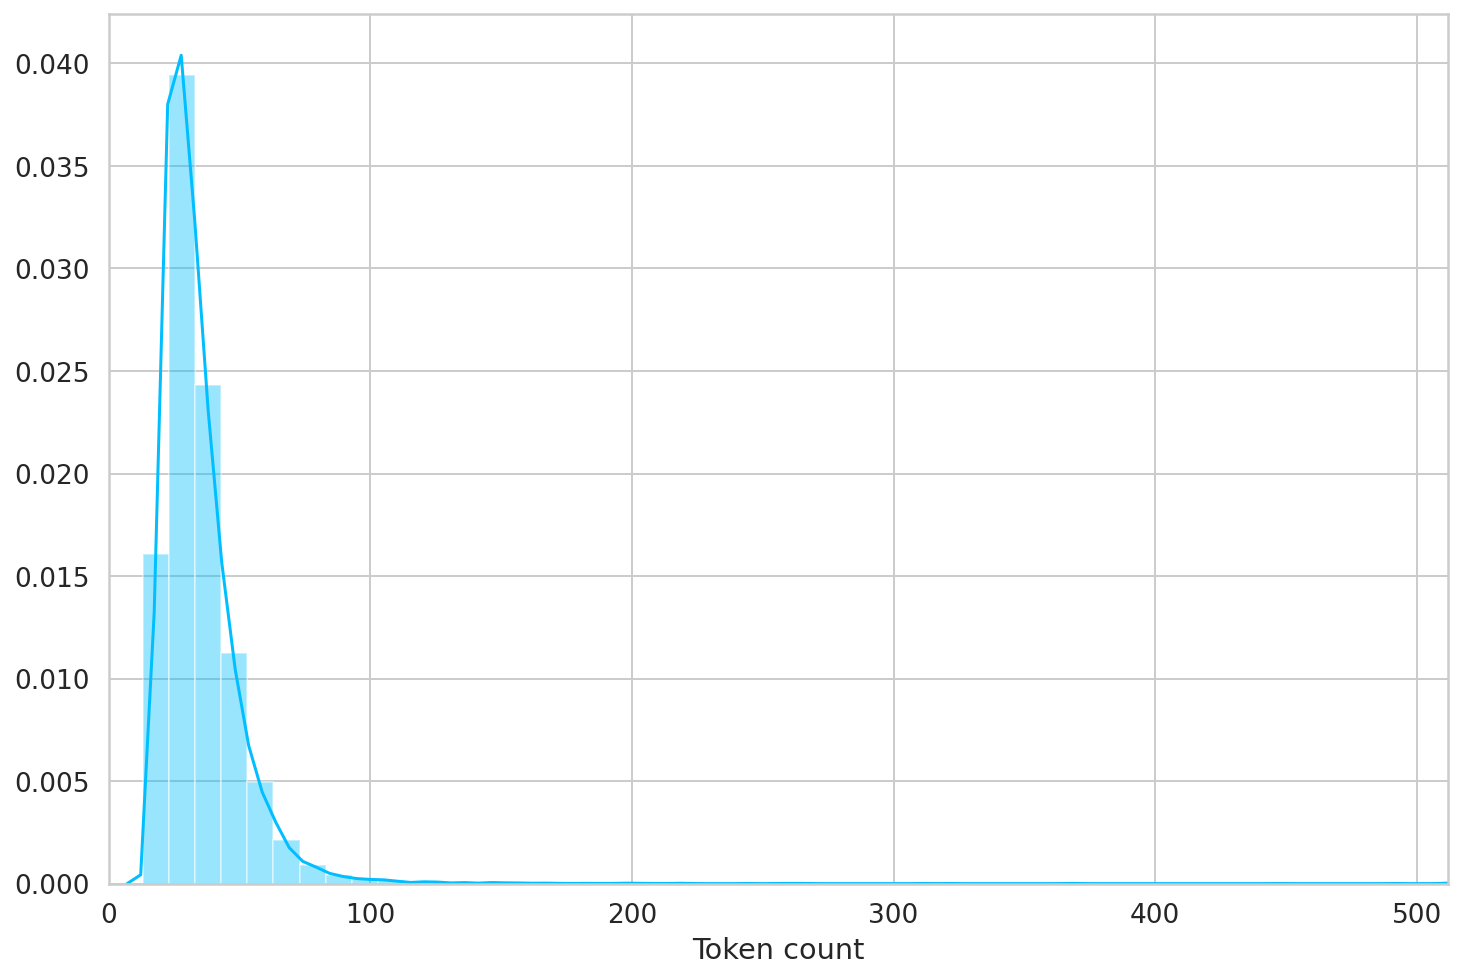

In [21]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

### Create Dataset

In [22]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [23]:
for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

Token distribution

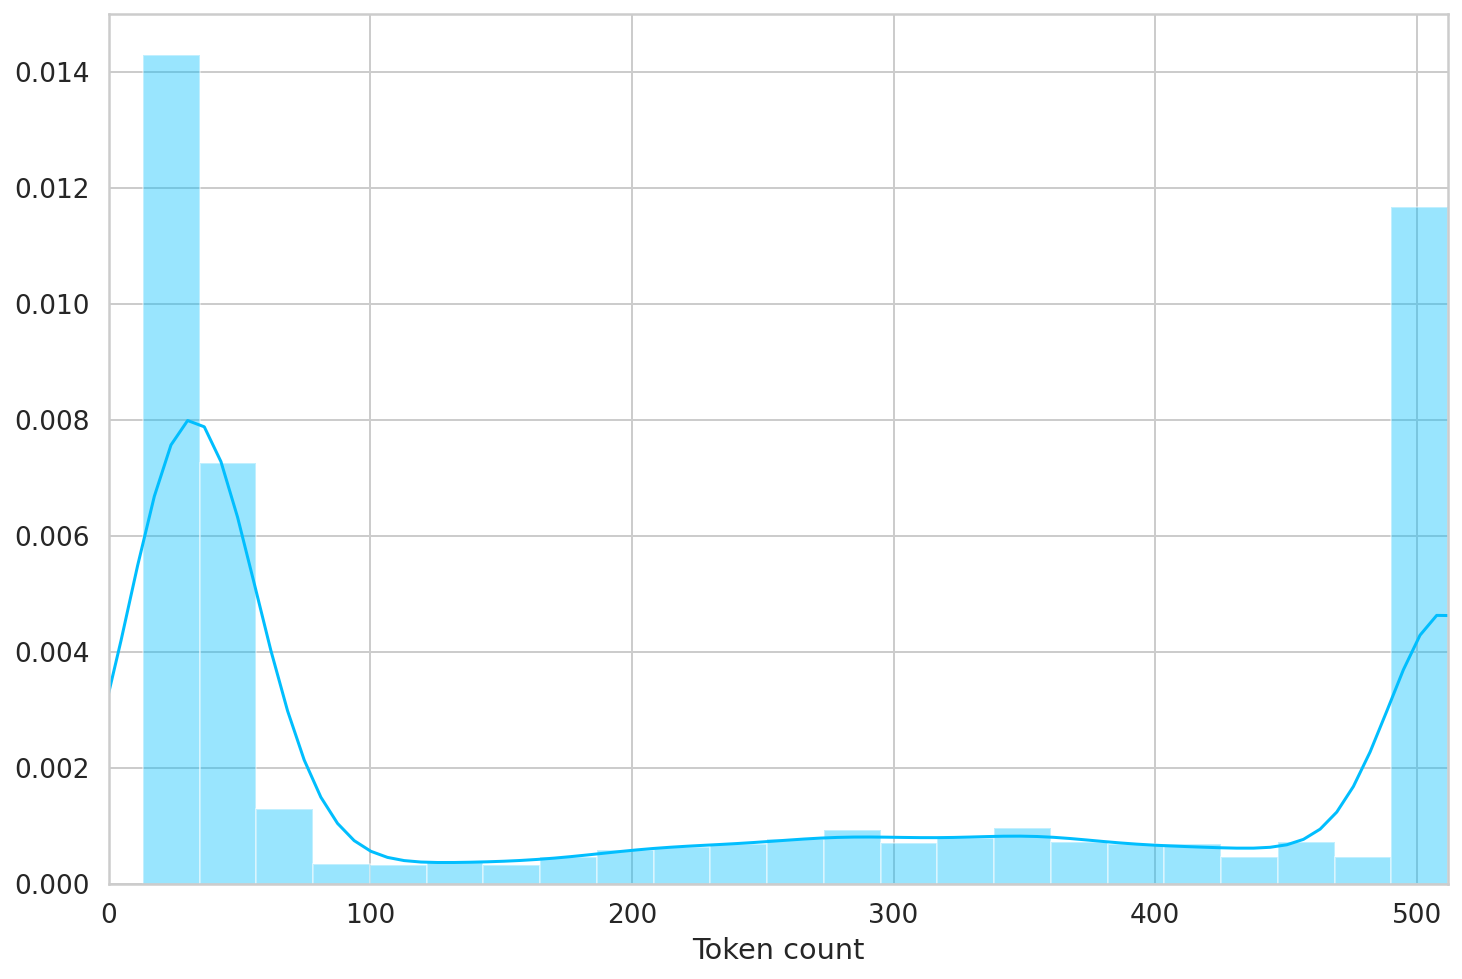

In [24]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [25]:
MAX_LEN = 512
# Run function `preprocessing_for_bert` on the train set and the validation set

print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Tokenizing data...


/home/leonardovida/.cache/pypoetry/virtualenvs/histaware-NidRwJ64-py3.8/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [26]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 10

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)

train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [27]:
class_names = ['Negative', 'Neutral', 'Positive']

### Sentiment classifier

In [13]:
#bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#config.hidden_dropout_prob = 0.3

In [28]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes, PRE_TRAINED_MODEL_NAME):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
            return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [40]:
#model = SentimentClassifier(len(class_names), "wietsedv/bert-base-dutch-cased")
#model = model.to(device)

### Helper method

In [30]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = SentimentClassifier(len(class_names), "wietsedv/bert-base-dutch-cased")

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [31]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode [ITS JUST A FLAG]
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch) #We take every tokenized sentence and put it to the gpu

            # Zero out any previously calculated gradients
            model.zero_grad() #Refresh the gradients before performing a backward pass

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask) #put b_labels 

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()
            #optimizer.zero_grad()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [32]:
from transformers import BertModel

set_seed(42)    # Set seed for reproducibility

bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
start = time.time()
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)
stop = time.time()
print(f"Training time: {stop - start}s")

Some weights of BertModel were not initialized from the model checkpoint at wietsedv/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


RuntimeError: Expected object of scalar type Long but got scalar type Double for argument #2 'target' in call to _thnn_nll_loss_forward

### Predict

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Testing

In [ ]:
holdout_sentences = holdout_df.text
holdout_label = holdout_df.labels

test_inputs, test_masks = preprocessing_for_bert(holdout_sentences) 

#coverting to torch
test_labels = torch.tensor(holdout_df.rating.array)
print(test_inputs.shape)

#create test Dataloader
test_data = TensorDataset(test_inputs,test_masks,test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data,sampler=test_sampler,batch_size=batch_size)

In [25]:
from sklearn.metrics import f1_score

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [26]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1)
    labels_flat = labels
    #print( )
    return f1_score(labels_flat, preds_flat, average='weighted')

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, holdout_label)

print("F1 score: ", f1_score_func(probs,holdout_label))
probs = np.argmax(probs, axis=1)
print("Precision Score: ", precision_score( holdout_label, probs ))
print("Recall Score: ", recall_score( holdout_label, probs ))

In [ ]:
#MACRO
print("Precision Score: ", precision_score( holdout_label, probs, average='macro' ))

# OLD: BERT Fine Tuning

## Old way of dataset

In [11]:
class HADataset(Dataset):
    # Characterizes a dataset for Pytorch
    def __init__(self, articles, labels, tokenizer, max_len):
        # Initialization
        self.articles = articles
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        # Total number of articles
        return len(self.articles)

    def __getitem__(self, item):
        # Generates one sample of the data/article
        article = str(self.articles[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            article,
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        return {
          'article_text': article,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

In [12]:
df_train, df_test = train_test_split(
  df,
  test_size=0.25,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [13]:
def create_data_loader(df, tokenizer, batch_size, num_workers, max_len):
    ds = HADataset(
        articles=df.text_split.to_numpy(),
        labels=df.labels.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    
    return DataLoader(
        ds,
        batch_size,
        num_workers
      )

### Use ImbSampling

In [15]:
#ros = RandomOverSampler(random_state=RANDOM_SEED)
#X_train_ros, y_train_ros = ros.fit_resample(df_train.text_split, df_train.labels)
#X_train = pd.DataFrame(X_train_ros, columns=X_train.columns)

ValueError: Expected 2D array, got 1D array instead:
array=['DEN HAAG - De Nederlandse huishoudens hebben vorig jaar zeven procent meer aardgas verbruikt dan het jaar ervoor. In hoofdzaak als gevolg van de strenge winter begin vorig jaar. Niettemin was de totale binnenlandse afzet van aardgas niet hoger dan in 1978. Dit als gevolg van het feit dat elektrische centrales op andere brandstoffen overschakelden en dus minder aardgas nodig hadden. •-" \'-\'.■\'. \'1 \',» < ■ De export van aardgas nam toe met negen procent en naderje de vijftig miljard kubieke .neter.'
 'Een bijkomend bezwaar is volgens de CDAer dat het kabinet de nota uitgebracht heeft vlak voordat het verkiezingsprogramma van zijn partij uitkomt. „Het is nog niet precies bekend hoe het daarin zal komen, maar kernenergie zal zeker niet omarmd worden", voorspelt Lansink. Het lag volgens het kamerlid wel voor de hand, dat het kabinet tot het genoemde standpunt is gekomen. De uitspraken van verscheidene ministers wezen al in die richting. Ook het kamerlid Braams (WD) is niet verbaasd over het gepresenteerde standpunt van de regering. Hij komt echter via een geheel andere redenering dan de christen-democraat tot deze uitspraak: „Andere oplossingen van het energievraagstuk dienen zich niet aan, waardoor geen andere conclusie mogelijk is dan een deel van onze energiebehoefte met kernenergie te vervullen". Het op grote schaal gebruiken van kolen brengt volgens Braams gigantische problemen met zich mee. Het vormt een ernstige bedreiging voor het milieu.'
 'Gemeenschappelijk is men het over één ding eens. Er zijn twee economische gebieden waarop de Sowjet-Unle pijnlijk te treffen Is, namelijk landbouw en energie. Concreet vertaald betekent dat een graanembargo, in te stellen door de Verenigde Staten, en een opzeggen van de gascontracten, hetgeen de Westeuropese landen zouden n oeten doen. Het zal geen verbazing wekken dat de Amerikanen in de NAVO aandringen op opzeggen van de gascontracten en de Europeanen op een graanembargo. Het gaat te ver om te zeggen dat hierover "gekibbeld" wordt in de NAVO, want zo gaan de Hoge Heren Bondgenoten niet met elkaar om. Maar wel. is het zo dat men elkaar er over en weer steeds aan herinnert. De Europeanen wijzen erop, zich baserend op berekeningen van de economische afdeling van de NAVO, dat de Sowjet-Unie dit jaar zeker 40 miljoen ton graan moet importeren, voornamelijk uit de Verenigde Staten. Een graanembargo zou de Russen ■ weliswaar niet in het hart treffen, maar toch wel in hun portemonnee, omdat het hen zou dwingen het graan tegen hogere prijzen via neutrale landen te kopen. t)e Amerikanen blijven hun Westeuropese bondgenoten ver- : tellen dat de Sowjet-Unie niet het enige land is met een enorme reserve aan aardgas. Ook de Golfstaten en Algerije beschikken over aardgas, zij het dat daarvoor een hogere prijs betaald moet worden dan voor het Russische gas. Deze situatie heeft het Amerikaanse blad The Washington . Post aanleiding gegeven tot het. maken van de volgende grap. Reagan en Schmidt zijn het eens geworden over sancties tegen de Sowjet-Unie.'
 ...
 'Over de hele wereld zijn er nog enorme mogelijkheden om steenkool te winnen maar financieel gezien moet Nederland ze zo dicht mogelijk bij huis zoeken. Letterlijk genomen liggen de mogelijkheden onder het huis,1 zoals nu blijkt. In eerste instantie ging na de energiecrisis de belangstelling uit naar aardolie en het daarbij behorende aardgas. De Nederlandse ondergrond werd met wetenschappelijke methoden verkend, waarna potentiële wingebieden door boringen nader werden afgetast en in kaart gebracht. De in Oost-Nederland ontdekte velden liggen op een diepte van 650 tot 900 meter, de Westnederlandse op 700 tot 2000 m. Bij het onderzoek van de genomen monsters bleek het Oostnederlandse gas „droog" aardgas te zijn d.w.z. afkomstig van steenkool. Eenmaal op het steenkoolspoor gekomen lag het voor de hand verder te zoeken naar gas- en steenkoolvoorkomens. Ze werden inderdaad ontdekt, maar liggen in de rest van het land (afgezien van de reeds bekende gebieden) veel dieper, evenals onder de Noordzee. Het Groningse (steenkool) gas bevindt zich op een diepte van 3000 m. De moedersteenkool ligt daar nog onder. Door middel van ongeveer tachtig diepboringen op het vasteland en in het Waddengebied is de ligging van het kolenvoerend gesteente nu over een dikte van meer dan 100 m globaal bekend. De Nederlandse kolenlagen vormen een onderdeel van één groot N.W.- Europees kolenbekken.'
 'DEN HAAG - „De daling van de olieprijzen op dit ogenblik zou sommige mensen ertoe kunnen brengen vragen te stellen bij verdergaande noodzaak van besparingen en diversificatie, d.w.z. andere dan de traditionele energiebronnen inzetten zoals olie en gas. We hebben zoveel geleerd uit de eerste maar vooral uit de tweede oliecrisis, dat we weten dat energiebeleid lange termijnbeleid is, waarbij je niet op de golven van het moment beleid mag voeren, maar heel nadrukkelijk doelstellingen moet nastreven die: 1. erop gericht zijn om zekerheid van de voorziening te waarborgen; 2. betaalbare d.w.z. goedkope energietarieven moge_ lijk maken; -£. stabiliteit van de prijzen garanderen; 4. rekening houden met de belangen van de ontwikkelingslanden, omdat zij vooral door de tweede crisis het hardst getroffen zijn. Nog harder dan onze economie." Aldus kort samengevat het credo\' dat - beleden dient te worden bij het vaststellen van de energiepolitiek voor de komende decennia zoals het Lim. burgse CDA-Kamerlid René van der Linden het ziet en zal verwoorden tijdens de Uitgebreide Commissie Vergadering die de Kamer op 5 maart aan dit onderwerp zal wijden. Toch dalen de olieprijzen onmiskenbaar, wat ook de oorzaak moge zijn. Is het niet redelijk dat daaruit profijt wordt getrokken? „De mensen die vandaag de dag zeggen: het hoeft niet meer zo nodig, die vergissen zich, omdat zij op dit moment geconfronteerd worden met een \'sing tussen OPEC-landen en niet-3EC landen, waaronder Engeland. it heeft naar mijn overtuiging een identeel karakter. Het kan een :-ital jaren duren, dat is op zich juist, maar wij moeten ervoor zorgen dat de ■energie-voorziening op lange termijn gewaarborgd wordt.'
 'Bij de sluiting van de laatste steenkoolmijn in Limburg enkele jaren geleden nestelde zich een verkeerd idee in de hoofden van de Nederlanders: de kolen zijn op; steenkool is als energiebron voor de industrie uitgeschakeld. Dat idee werd nog versterkt door het feit dat steenkool niet kan concurreren tegen olie en gas. Bovendien waren velen blij met het wegvallen van steenkool als energiebron, omdat de verbranding van steenkool in hoge mate milieuonvriendelijk is. Momenteel wordt steenkool weer hoogst actueel. De wereldreserves zijn nog lang niet uitgeput en zelfs veel rijker dan die van olie en gas.'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# Parameters
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

batch_size = 8
num_workers = 0
max_epochs = 100

# Create dataloaders
train_data_loader = create_data_loader(df_train, tokenizer, batch_size, num_workers, 350)
val_data_loader = create_data_loader(df_val, tokenizer, batch_size, num_workers, 350)
test_data_loader = create_data_loader(df_test, tokenizer, batch_size, num_workers, 350)

In [30]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [31]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)
        
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        
        loss = loss_fn(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        
        losses.append(loss.item())
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)

In [32]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [33]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
      )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
      )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------


TypeError: dropout(): argument 'input' (position 1) must be Tensor, not str

### Training history

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evaluation

In [38]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.6928327645051194

In [39]:
def get_predictions(model, data_loader):
    model = model.eval()
    article_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["article_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            article_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(labels)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return article_texts, predictions, prediction_probs, real_values

In [40]:
y_article_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [41]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.67      0.74      0.70       100
     Neutral       0.76      0.74      0.75       164
    Positive       0.36      0.28      0.31        29

    accuracy                           0.69       293
   macro avg       0.60      0.58      0.59       293
weighted avg       0.69      0.69      0.69       293



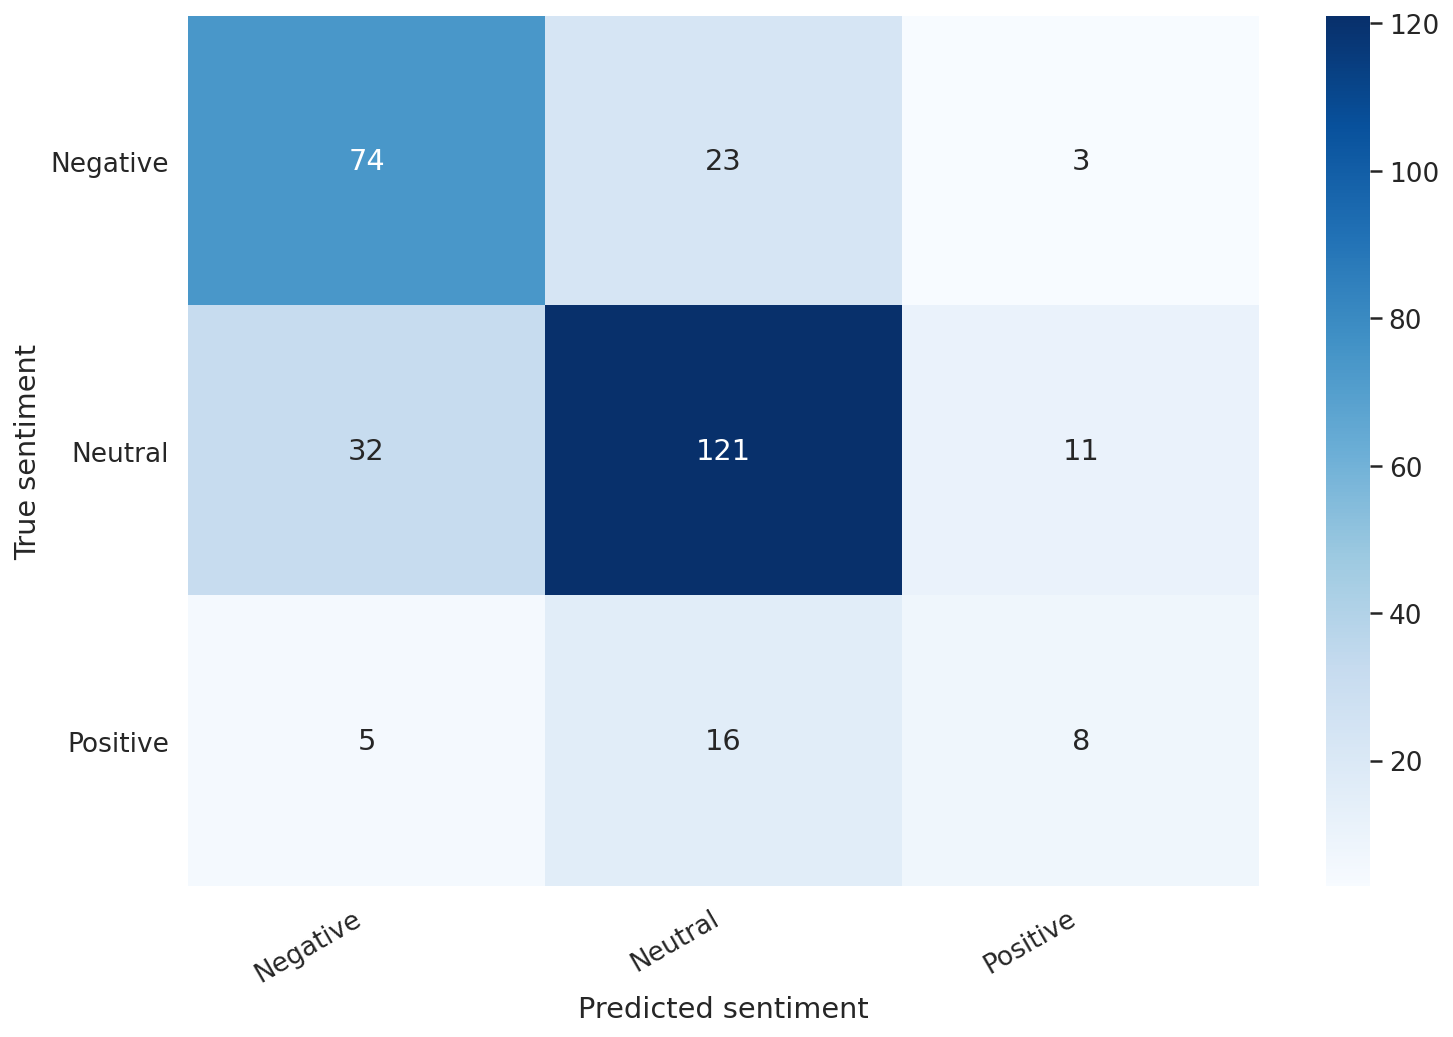

In [42]:
def show_confusion_matrix(confusion_matrix):
    
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Print example

In [43]:
idx = 2
article_text = y_article_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [44]:
print("\n".join(wrap(article_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

En dat wilden we niet.",.. ' De binnenvaartvloot van Shell, waarmee
jarenlang, de produkten vanaf de raffinaderij in Pernis naar afnemers
en depots in heel Nederland werden vervoerd, bestaat sinds kort niet
meer. Eind december werd het laatste ' schip, de Shell 4, aan de
Verenigde Tankrederij verkocht die het onder de naam Vlieland in de
vaart heeft gebracht. Hiermee eindigde een geschiedenis die# in 1902
met de ingebruikname' van een raffinaderij aan de Sluisjesdijk was
begonnen. .. Den Haan heeft die geschiedenis in de afgelopen drie jaar
vastgelegd, foto's verzameld, met gepensioneerden gesproken en
archieven doorgeplozen. Het boek was in eerste instantie bestemd voor
bij de vloot betrokken Shell-personeel en oud-medewerkers.

True sentiment: Neutral


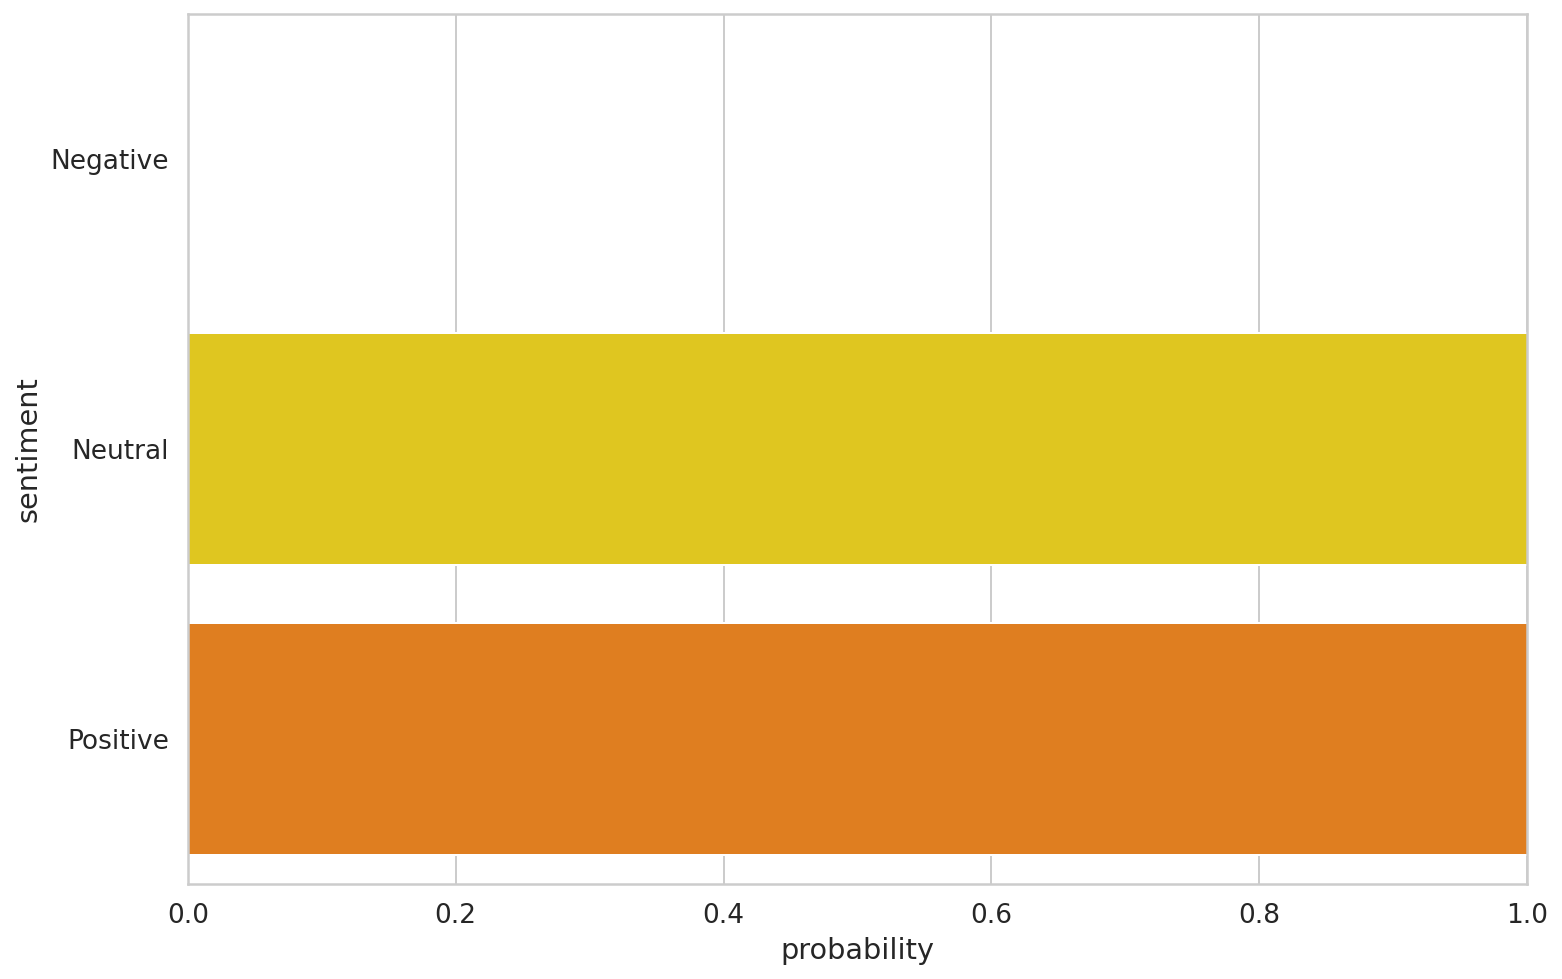

In [45]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting new articles

In [46]:
encoded_article = tokenizer.encode_plus(
    article_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

/home/leonardovida/.cache/pypoetry/virtualenvs/histaware-JJpORNNs-py3.8/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1938: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [47]:
input_ids = encoded_article['input_ids'].to(device)
attention_mask = encoded_article['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {article_text}')
print(f'Predicted sentiment: {class_names[prediction]}')
print("-----------")

Review text: En dat wilden we niet.",.. ' De binnenvaartvloot van Shell, waarmee jarenlang, de produkten vanaf de raffinaderij in Pernis naar afnemers en depots in heel Nederland werden vervoerd, bestaat sinds kort niet meer. Eind december werd het laatste ' schip, de Shell 4, aan de Verenigde Tankrederij verkocht die het onder de naam Vlieland in de vaart heeft gebracht. Hiermee eindigde een geschiedenis die# in 1902 met de ingebruikname' van een raffinaderij aan de Sluisjesdijk was begonnen. .. Den Haan heeft die geschiedenis in de afgelopen drie jaar vastgelegd, foto's verzameld, met gepensioneerden gesproken en archieven doorgeplozen. Het boek was in eerste instantie bestemd voor bij de vloot betrokken Shell-personeel en oud-medewerkers.
Predicted sentiment: Neutral
-----------
